In [1]:
import os
os.environ['TEMPESTEXTREMESDIR']='/home/565/mb0427/gdata-gb02/tempestextremes/bin'
os.environ['WXSYSLIBDIR']='/g/data/gb02/mb0427/WxSysLib'
import sys
sys.path.append(os.environ['WXSYSLIBDIR'])

In [2]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import xarray as xr
import pandas as pd
import subprocess
from tqdm import tqdm

In [3]:
from utils.date_utils import generate_datetimes,generate_datetimes_months
from utils.nci_utils import get_GADI_ERA5_filename
from utils.file_utils import write_to_filelist,create_directory,read_filelist

from tempestextremes_utils.blob_wrappers import create_Blob_dirstruct,run_detectBlobs,run_stitchBlobs,run_statBlobs,read_statBlobs
from tempestextremes_utils.blob_utils import merge_and_split_blob_dfs,separate_blobs_by_closest_cents

from plotting.blob_plotting import plot_tracks_at_time

In [4]:
datapath='/home/565/mb0427/gdata-gb02/blocking/ERA5/z500_anoms_sh/'
casename='z500_anom_test_psh'
create_Blob_dirstruct('/home/565/mb0427/gdata-gb02/tempestextremes/',casename)
casepath='/home/565/mb0427/gdata-gb02/tempestextremes/'+casename+'/'
os.chdir(casepath) # change the path to get the outlog in the right place

Directory '/home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh' already exists.
Directory '/home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/detectBlobs' already exists.
Directory '/home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/stitchBlobs' already exists.
Directory '/home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs' already exists.


In [5]:
datetimes=generate_datetimes_months(datetime(2009,1,1),datetime(2009,3,1),interval=1)
date_id=[dt.strftime('%Y%m') for dt in datetimes]
data_filenames=[datapath+'z500_era5_oper_pl_anom_doy_366_sh_'+y+'.nc' for y in date_id]
detect_filenames=[casepath+'detectBlobs/detectBlobs_'+casename+'_'+y+'.nc' for y in date_id]
stitch_filenames=[casepath+'stitchBlobs/stitchBlobs_'+casename+'_'+y+'.nc' for y in date_id]
stitch_stat_file=casepath+'statBlobs/stats_stitchBlobs_'+casename+'.txt'
detect_stat_file=casepath+'statBlobs/stats_detectBlobs_'+casename+'.txt'

In [6]:
input_filelist=casepath+'input_files.txt'
write_to_filelist(data_filenames,input_filelist)
detect_filelist=casepath+'detectBlobs/detect_files.txt'
write_to_filelist(detect_filenames,detect_filelist)
stitch_filelist=casepath+'stitchBlobs/stitch_files.txt'
write_to_filelist(stitch_filenames,stitch_filelist)

In [7]:
run_detectBlobs(input_filelist,detect_filelist,quiet=True,clean=True,
                    threshold_var="z_anom",threshold_op=">=",threshold_val=1000.0,threshold_dist=0.,
                    geofilterarea_km2=5e5,   
                    lonname="longitude",latname="latitude")

Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/detectBlobs/detectBlobs_z500_anom_test_psh_200901.nc
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/detectBlobs/detectBlobs_z500_anom_test_psh_200902.nc
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/detectBlobs/detectBlobs_z500_anom_test_psh_200903.nc
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/detectBlobs/detectBlobs_errlog.txt
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/detectBlobs/detectBlobs_outlog.txt


In [8]:
run_statBlobs(detect_filelist,detect_stat_file,quiet=True,clean=True,
                       var='binary_tag',findblobs=True,
                       outstats='minlat,maxlat,minlon,maxlon,centlon,centlat,area')

Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs/stats_detectBlobs_z500_anom_test_psh.txt
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs/statBlobs_errlog.txt
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs/statBlobs_outlog.txt


In [9]:
run_stitchBlobs(detect_filelist,stitch_filelist,quiet=True,clean=True,mpi_np=1,
                            minsize=1,
                            #minlat=-90.0,maxlat=0.0,
                            min_overlap_prev=0.,max_overlap_prev=100.,
                            min_overlap_next=0.,max_overlap_next=100.,
                            lonname="longitude",latname="latitude")

Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/stitchBlobs/stitchBlobs_z500_anom_test_psh_200902.nc
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/stitchBlobs/stitchBlobs_z500_anom_test_psh_200903.nc
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/stitchBlobs/stitchBlobs_z500_anom_test_psh_200901.nc
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/stitchBlobs/stitchBlobs_errlog.txt
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/stitchBlobs/stitchBlobs_outlog.txt


In [10]:
run_statBlobs(stitch_filelist,stitch_stat_file,quiet=True,clean=True,
                       var='object_id',findblobs=False,
                       outstats='minlat,maxlat,minlon,maxlon,centlon,centlat,area')

Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs/stats_stitchBlobs_z500_anom_test_psh.txt
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs/statBlobs_errlog.txt
Deleted: /home/565/mb0427/gdata-gb02/tempestextremes/z500_anom_test_psh/statBlobs/statBlobs_outlog.txt


In [11]:
df_stitch=read_statBlobs(stitch_stat_file)
df_detect=read_statBlobs(detect_stat_file)

In [12]:
df_final=merge_and_split_blob_dfs(df_stitch, df_detect, 
          timename='datetime',
          byvec=["datetime", "area"])
df_final2=separate_blobs_by_closest_cents(df_final)

/g/data/gb02/mb0427/WxSysLib/tempestextremes_utils/blob_utils.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_istot["bnum2"] = df_istot["bnum_x"]
/g/data/gb02/mb0427/WxSysLib/tempestextremes_utils/blob_utils.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_isnot["bnum2"] = df_isnot["bnum_y"]


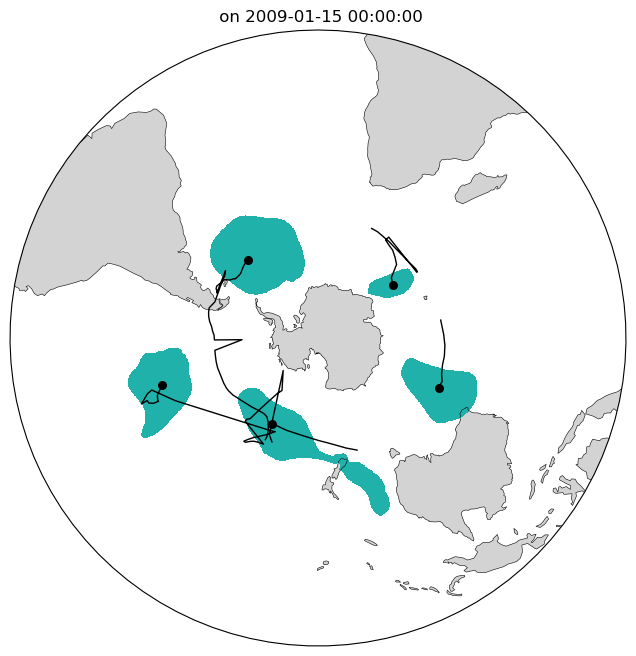

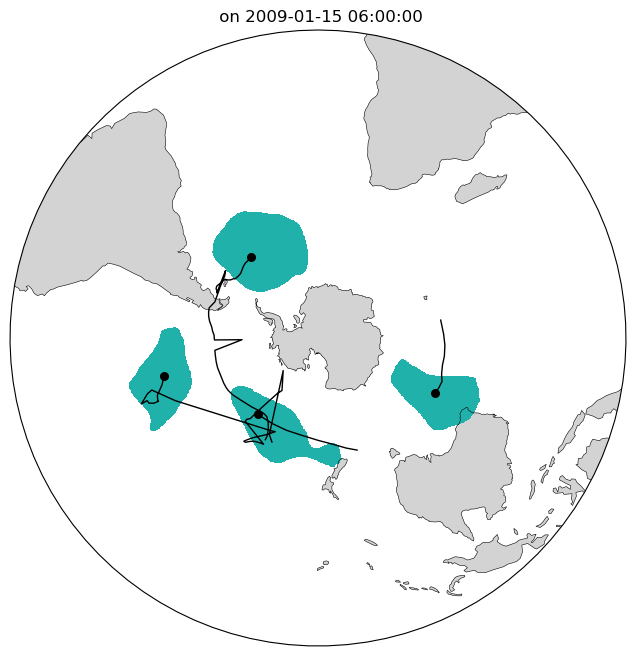

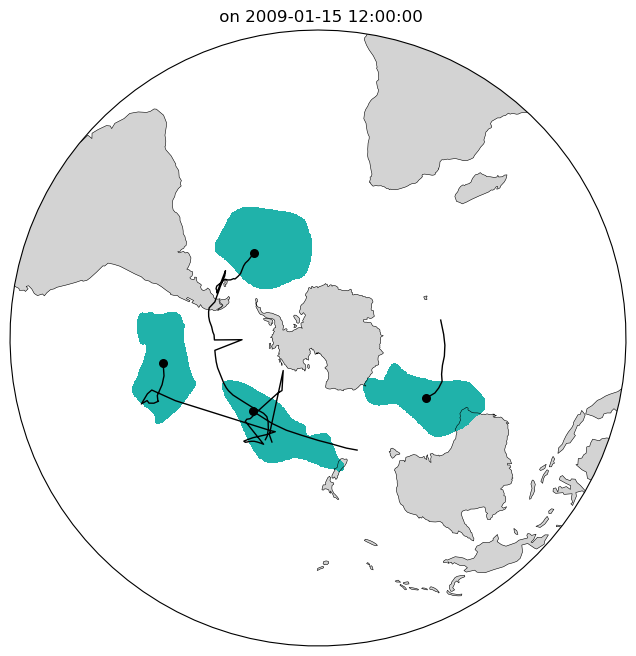

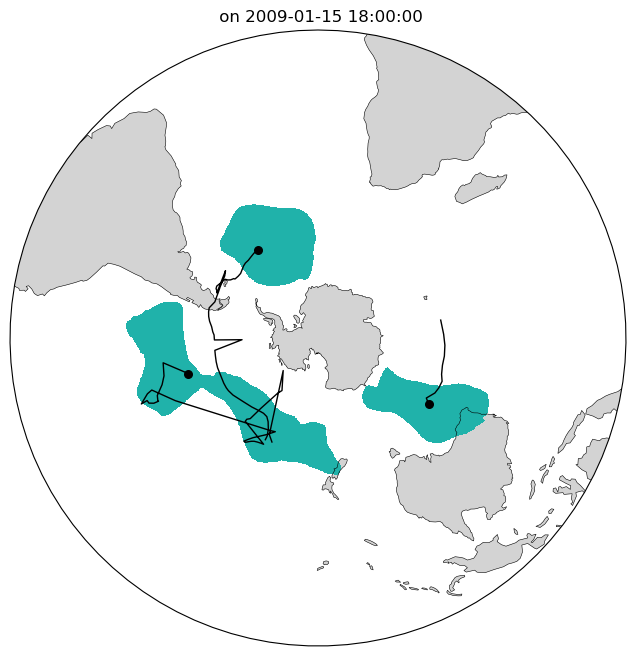

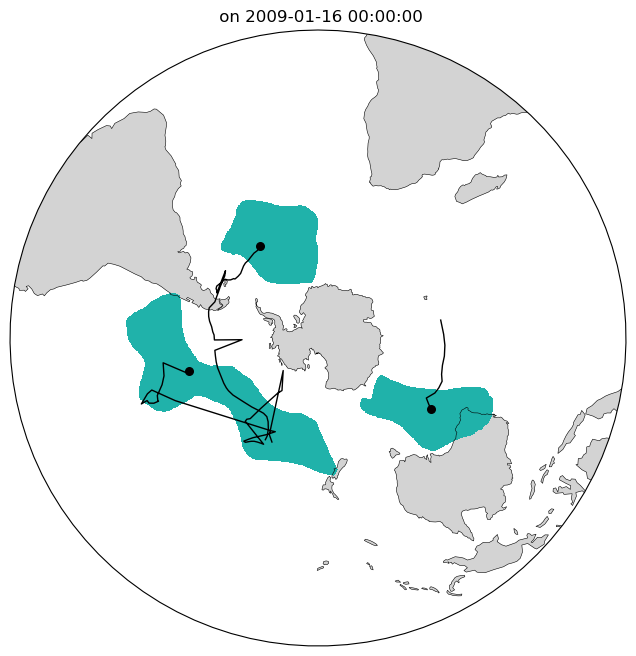

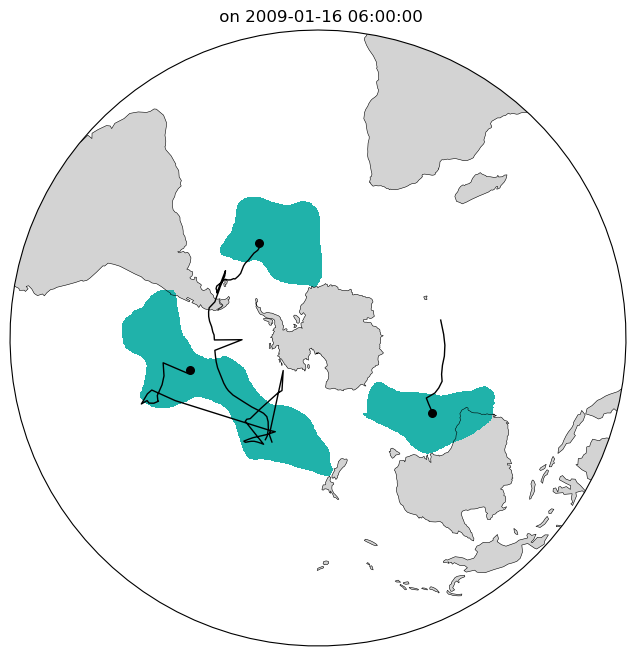

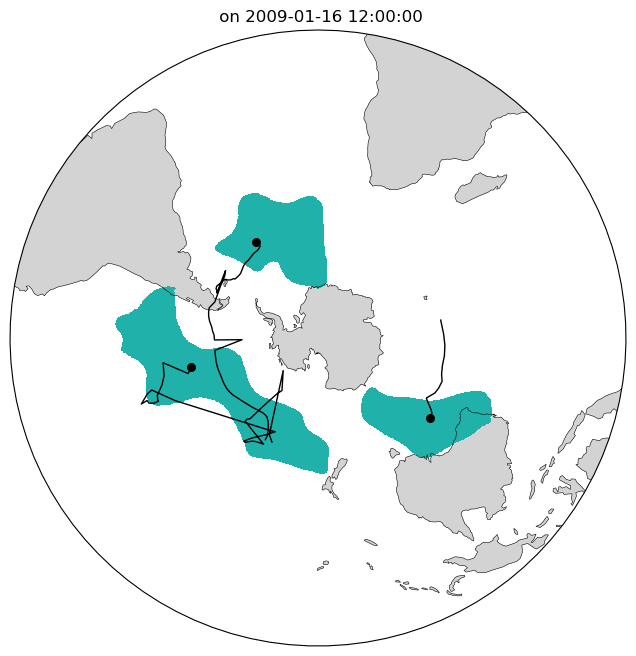

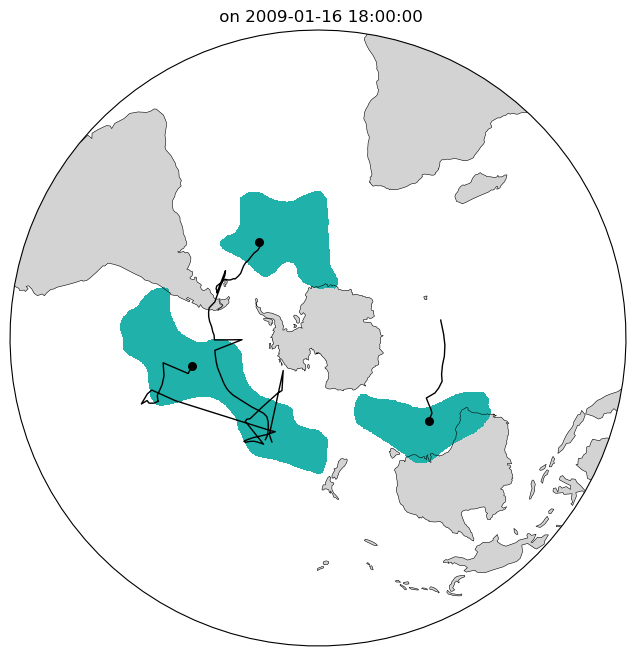

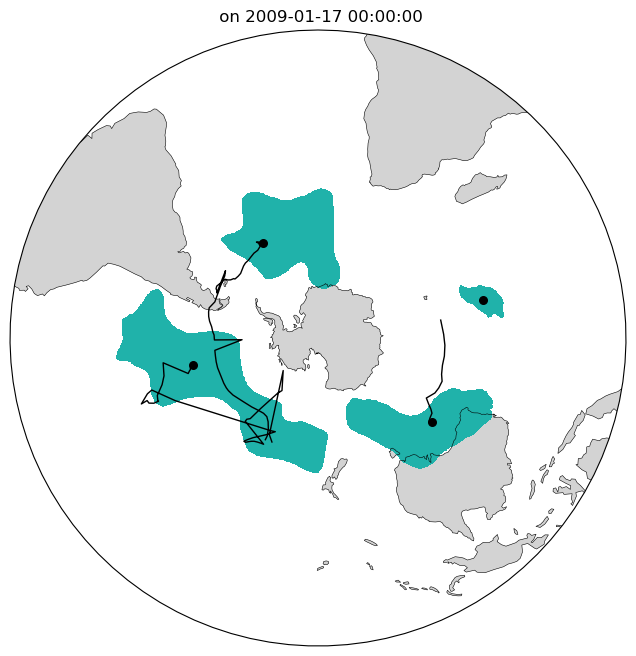

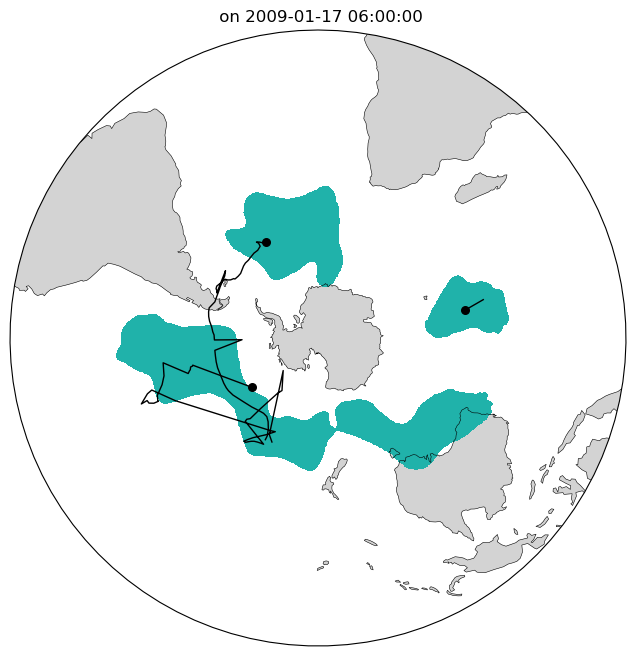

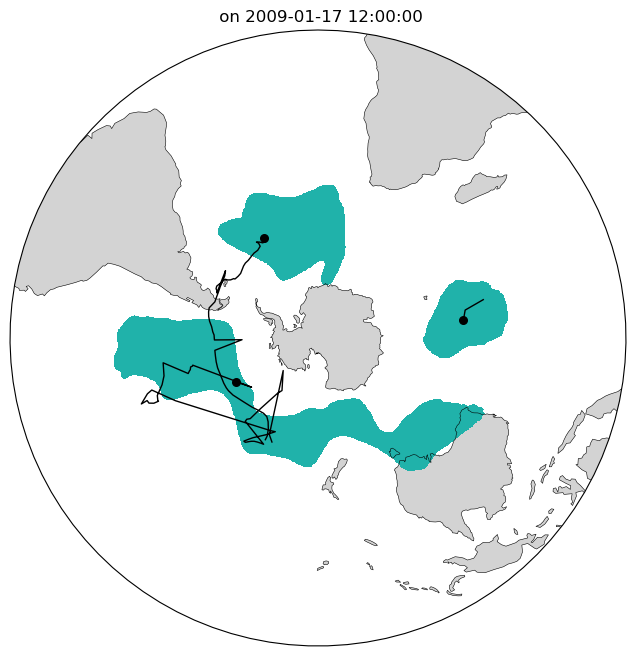

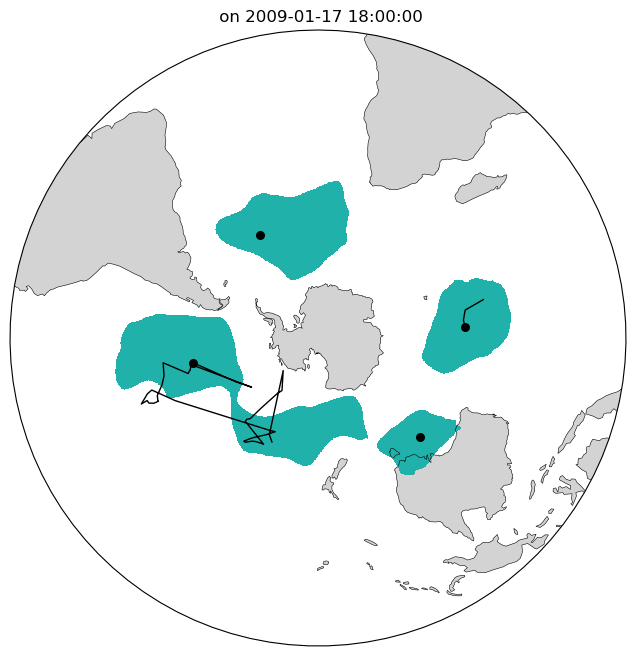

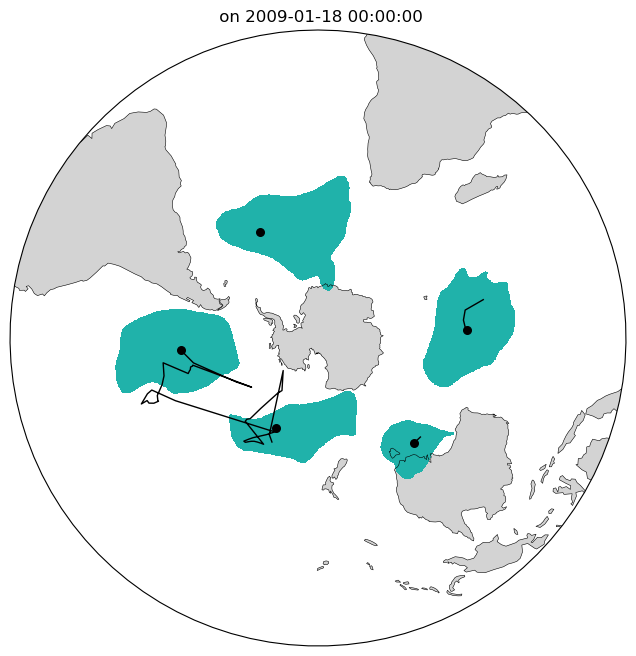

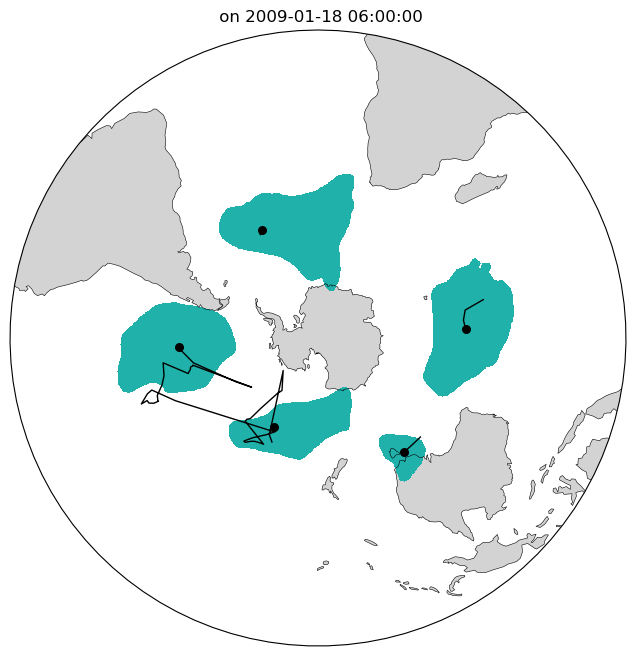

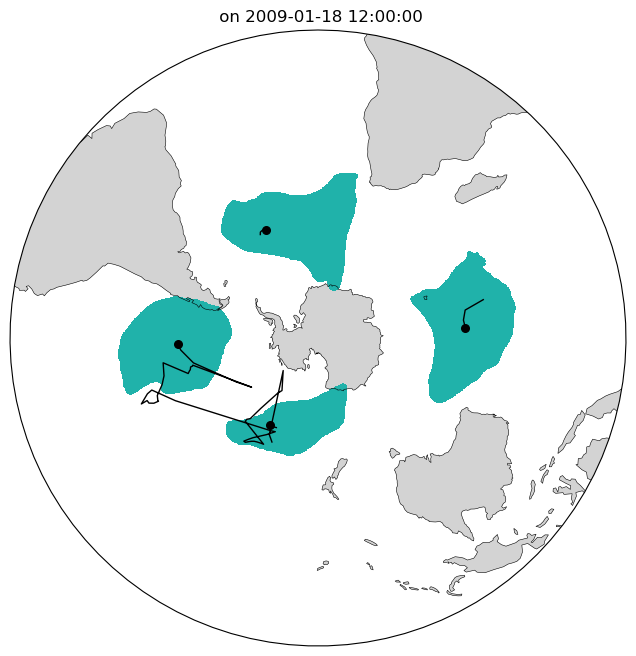

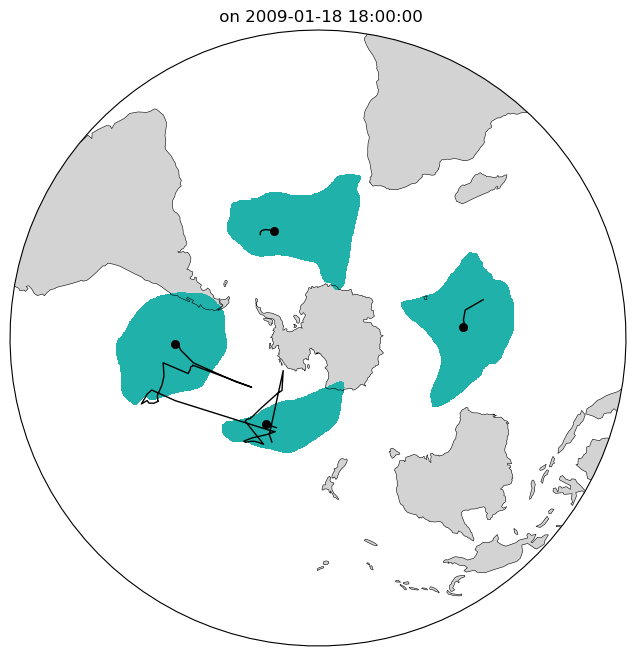

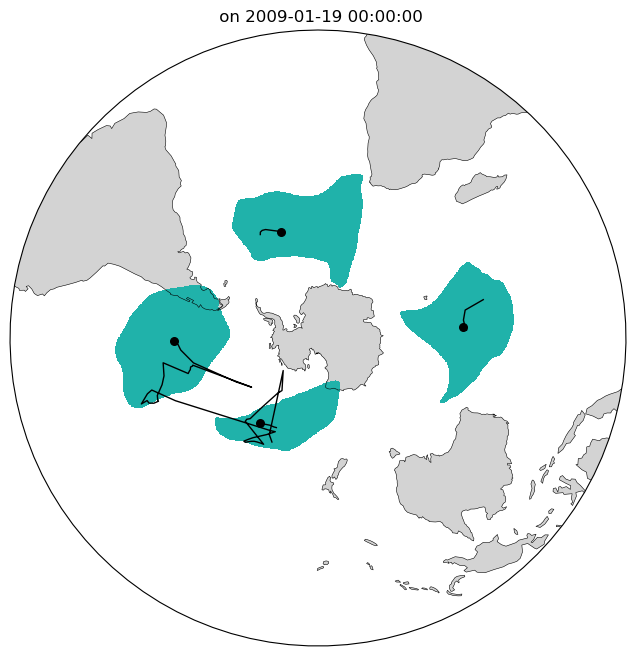

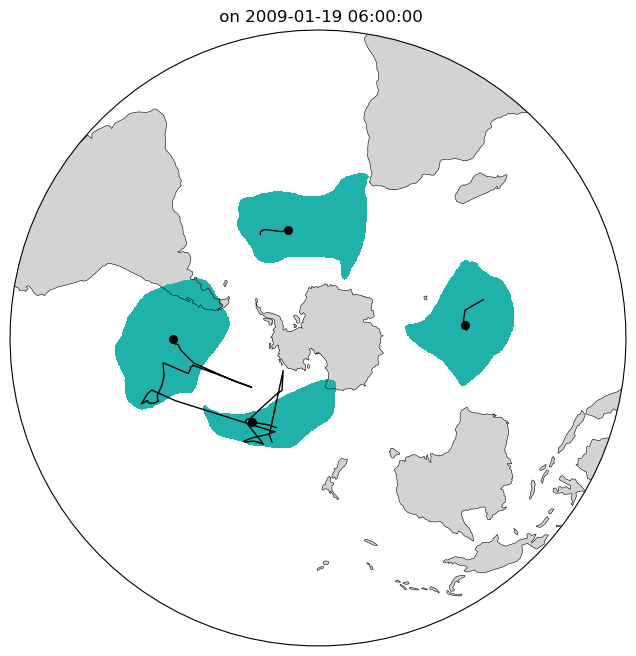

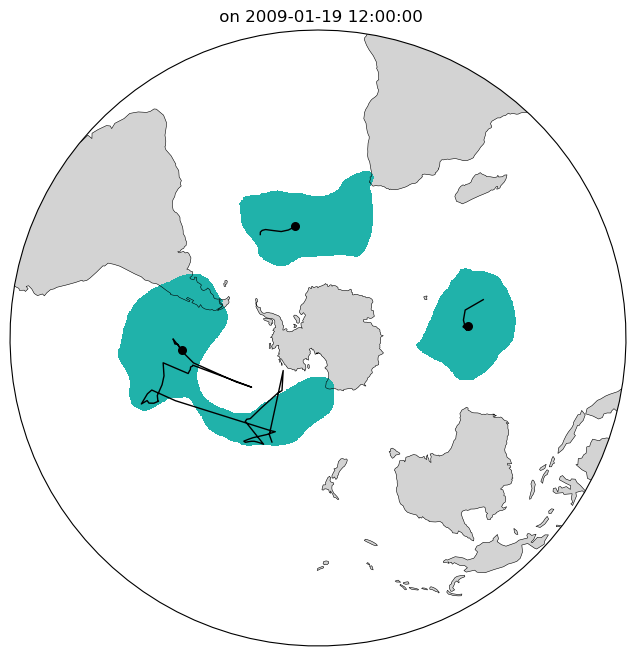

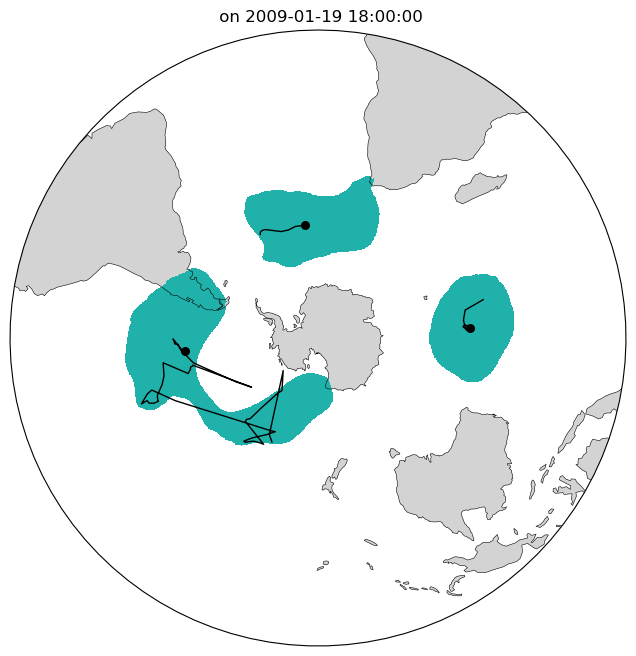

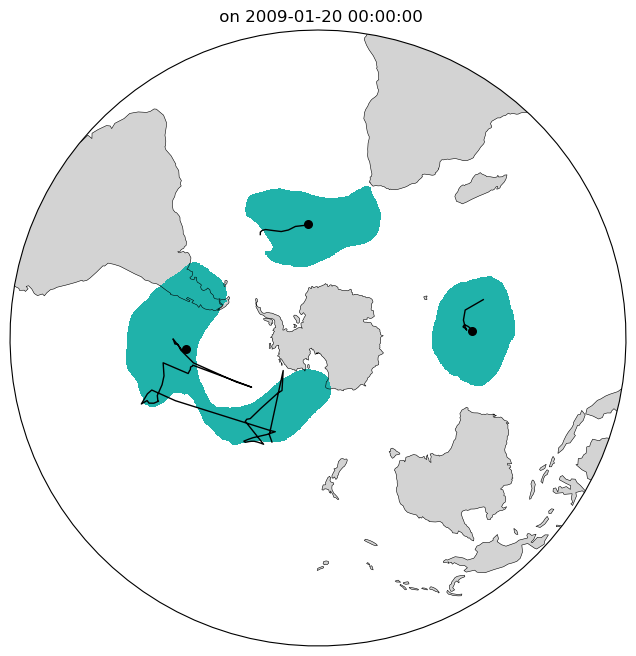

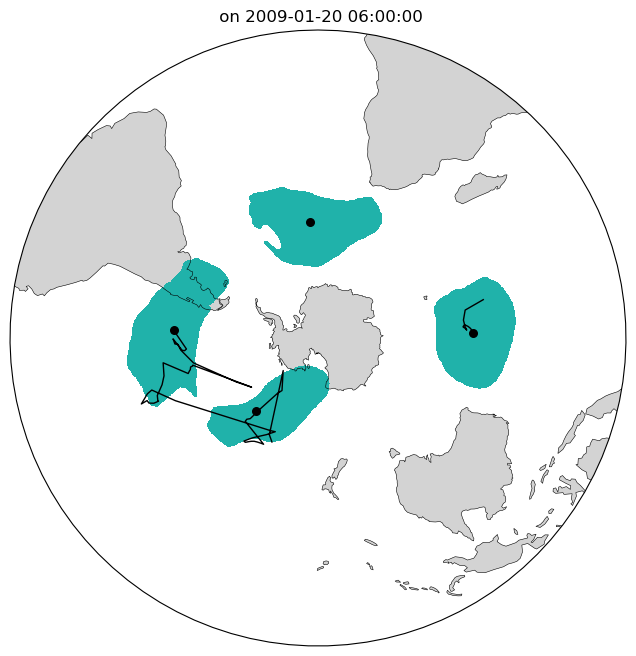

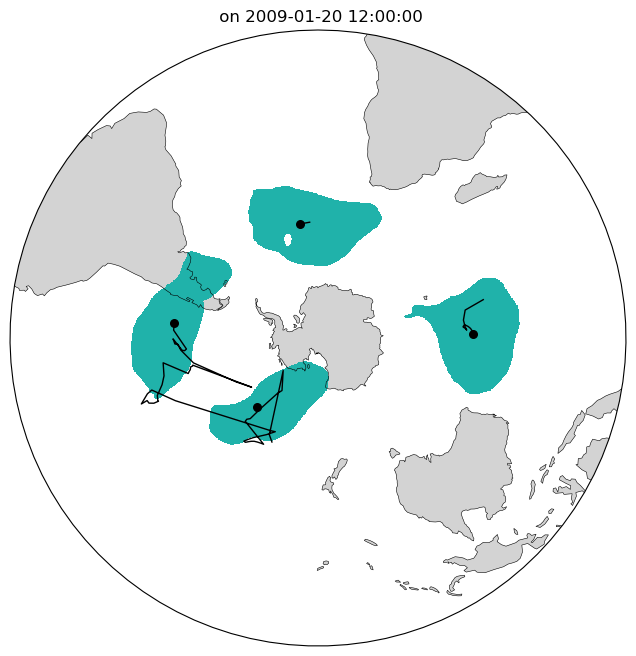

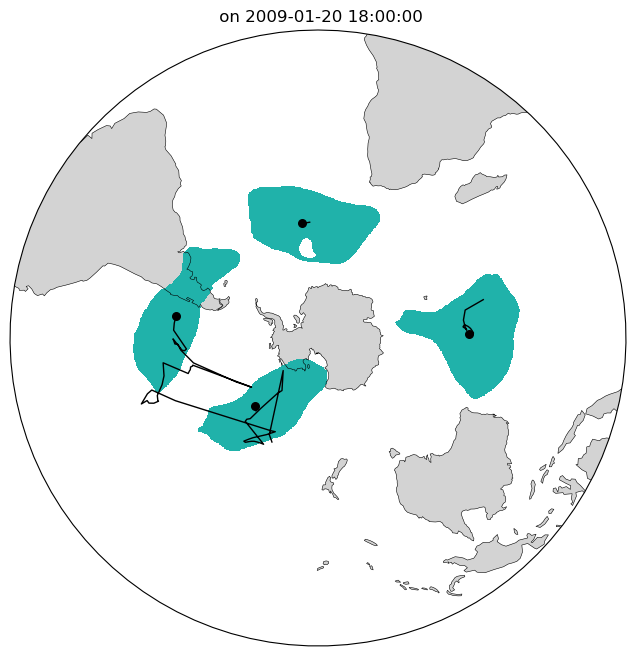

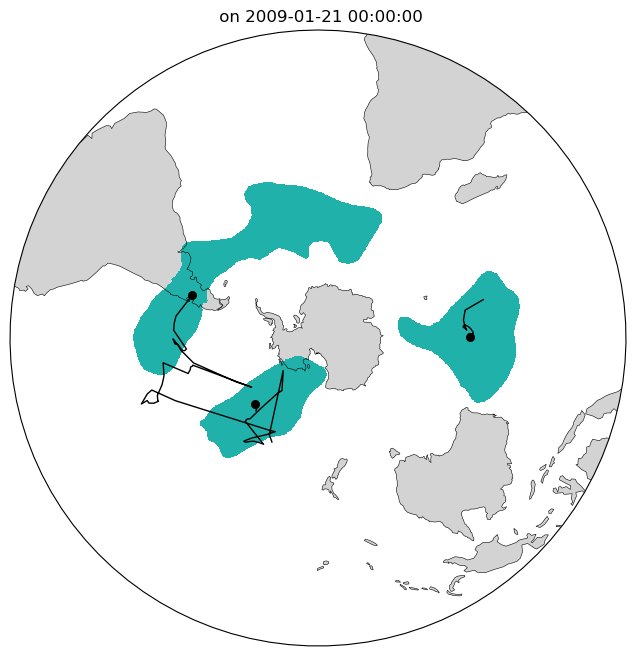

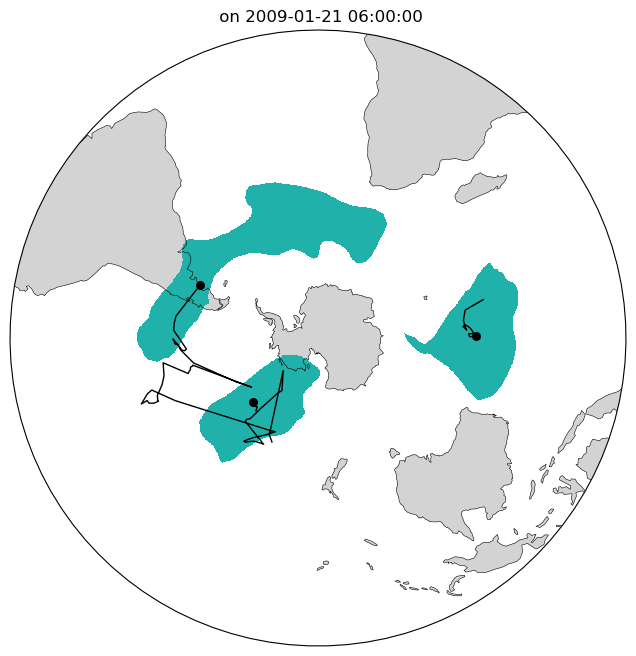

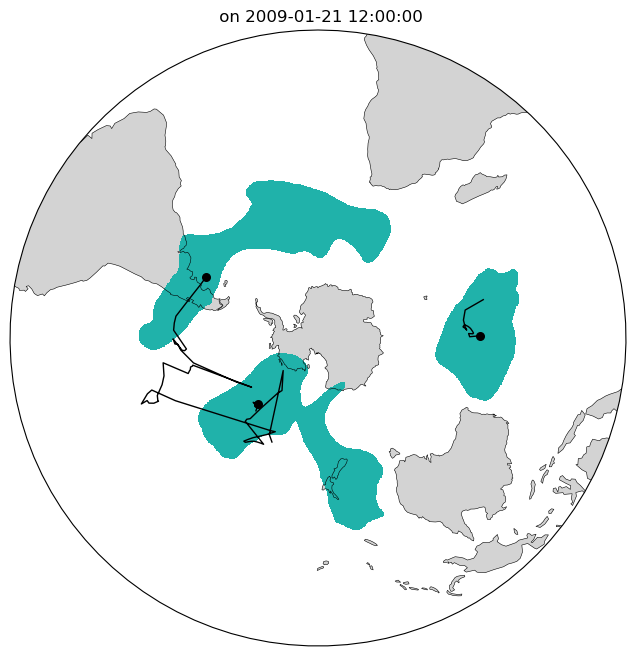

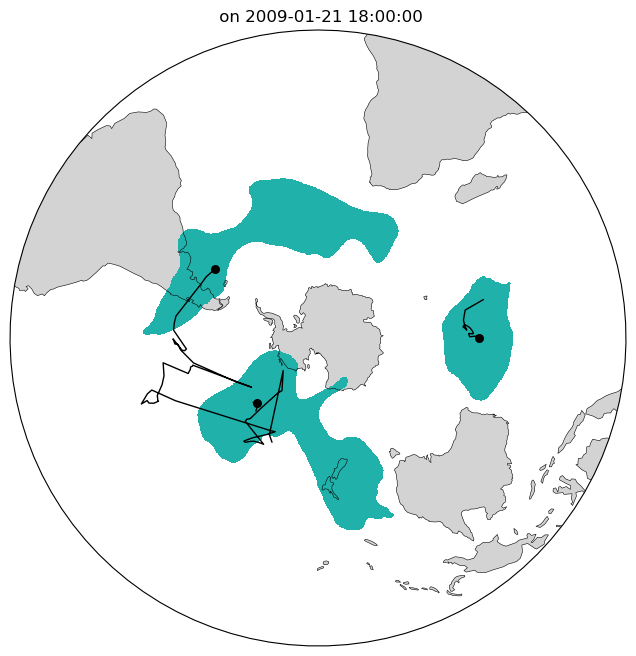

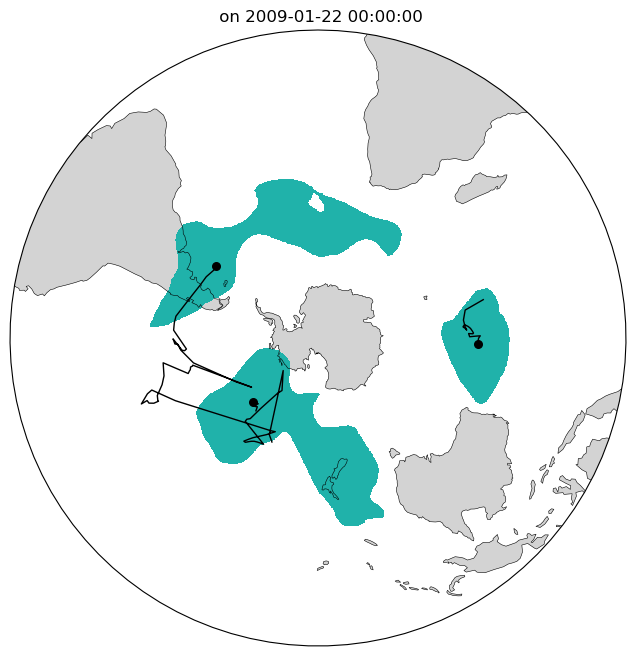

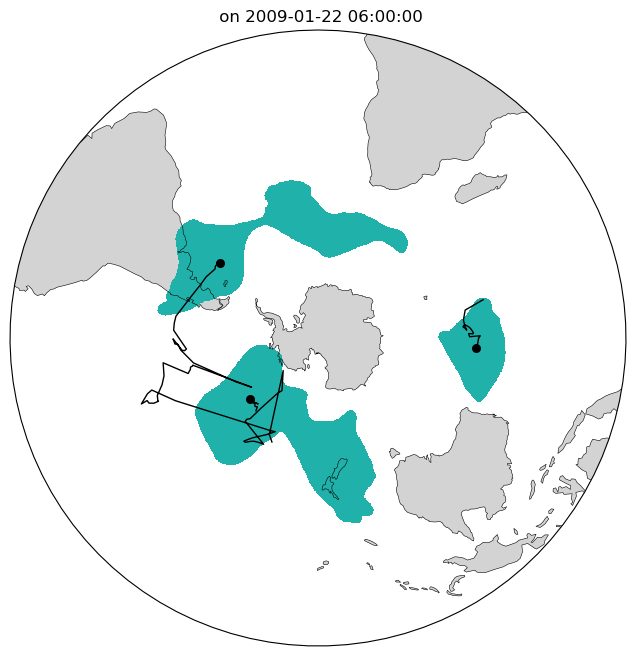

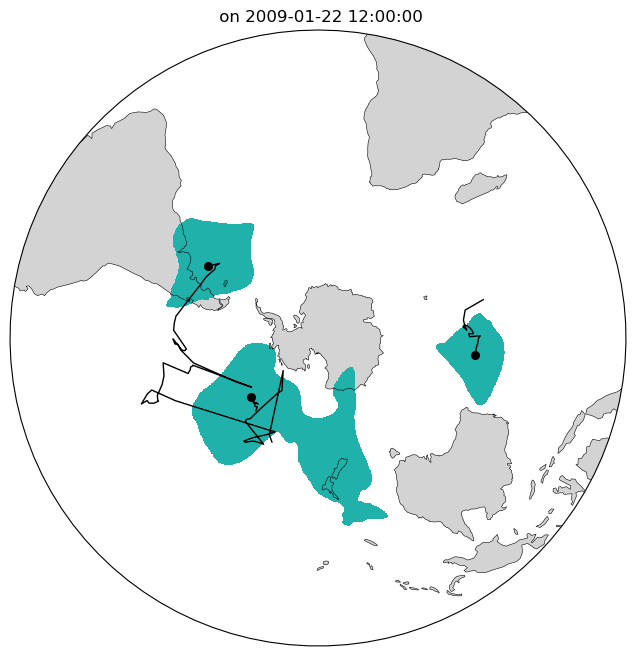

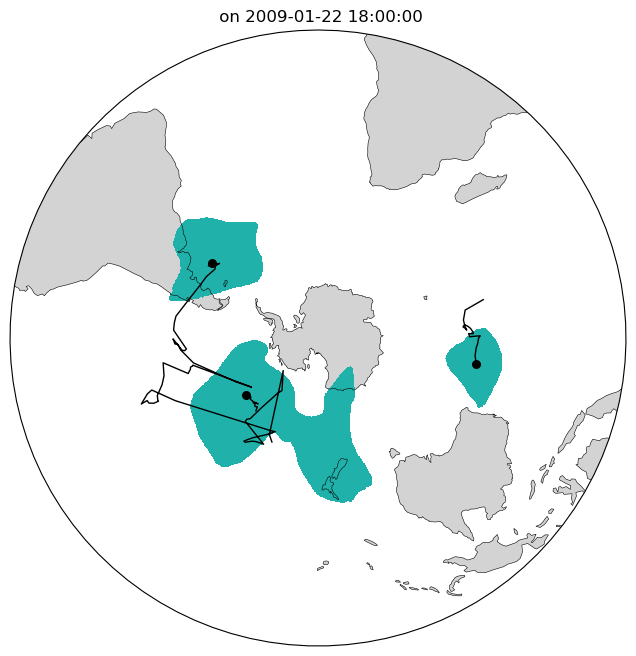

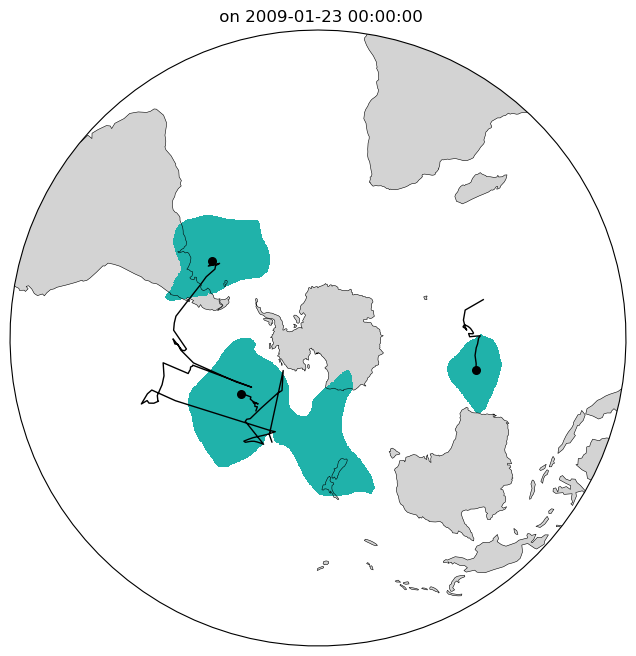

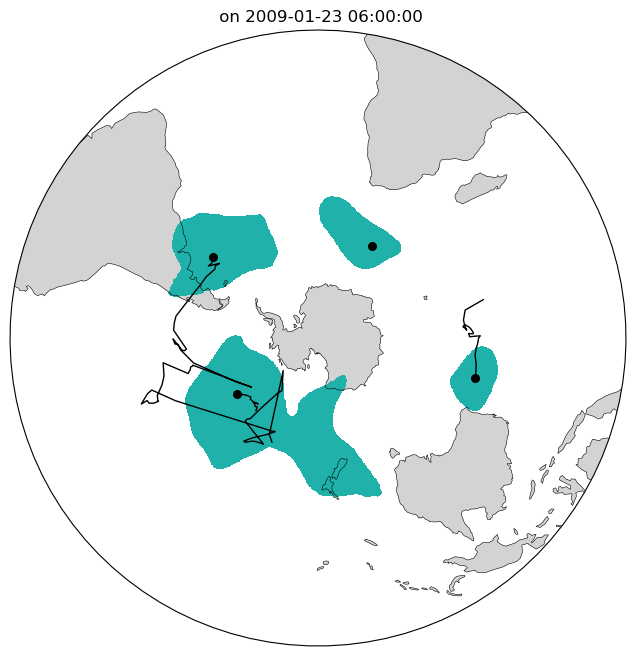

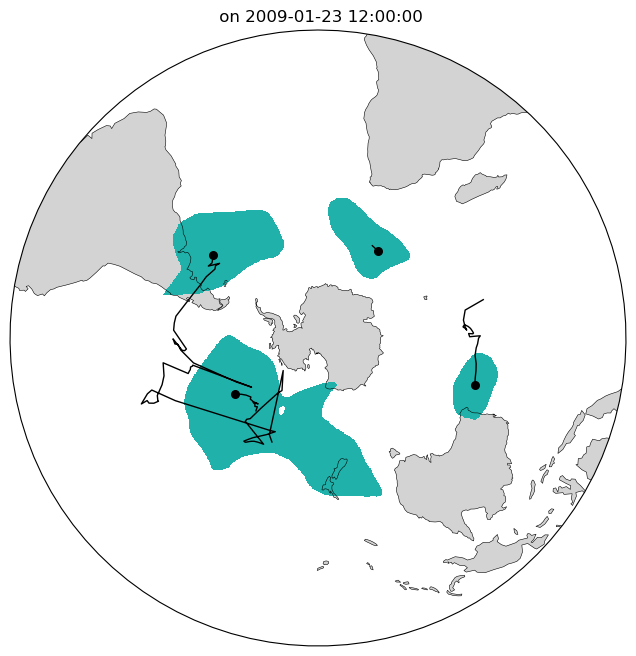

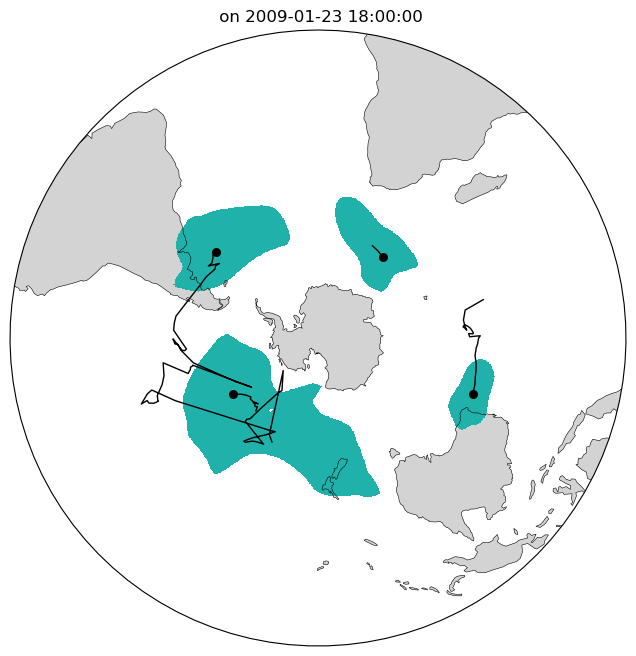

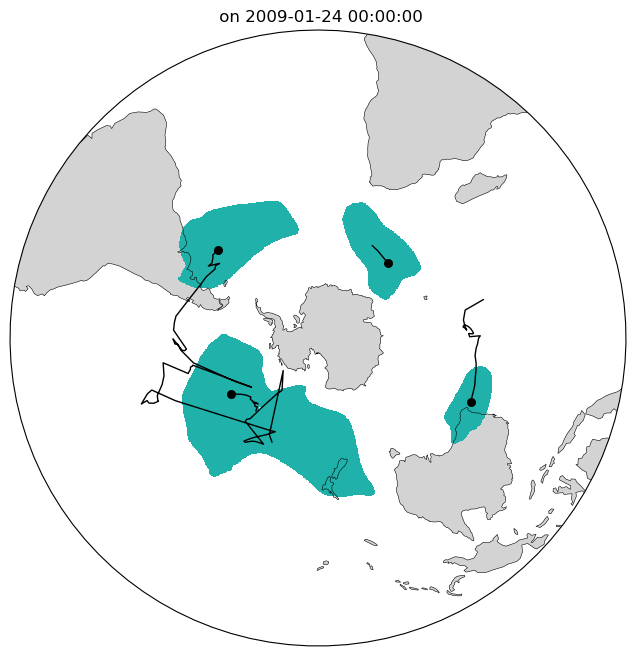

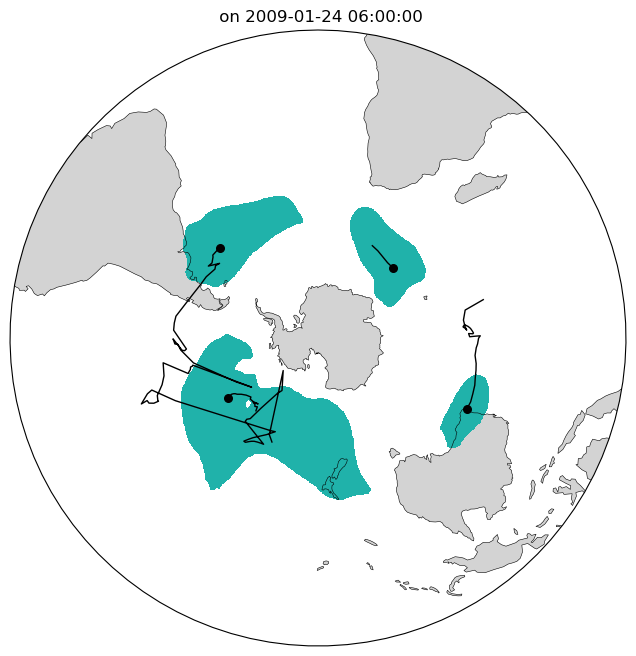

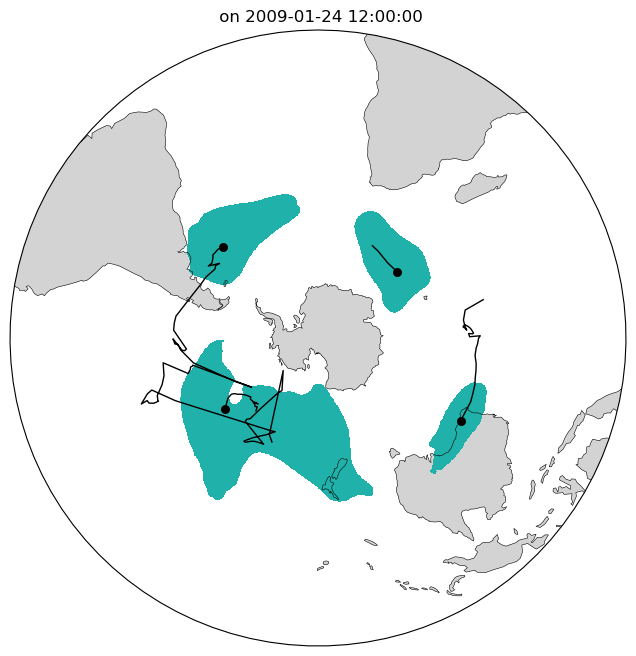

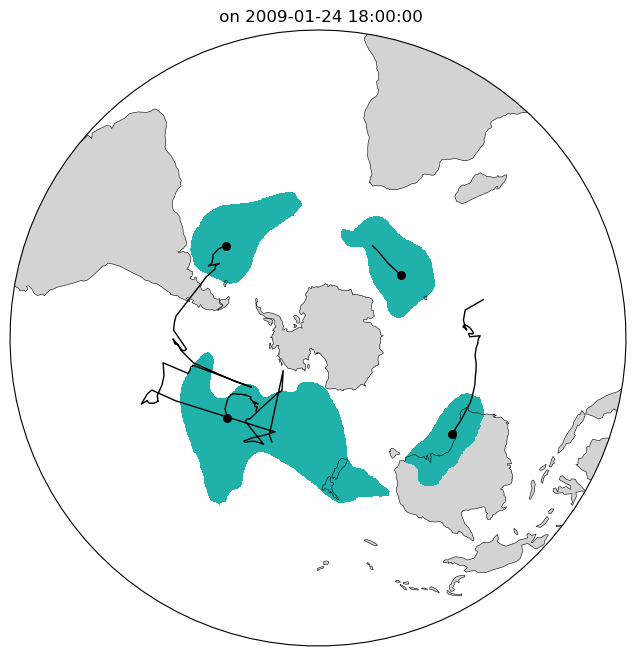

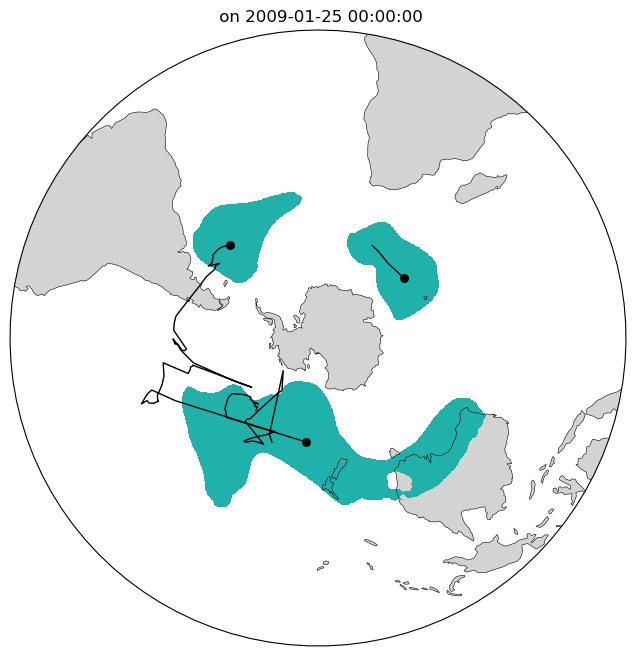

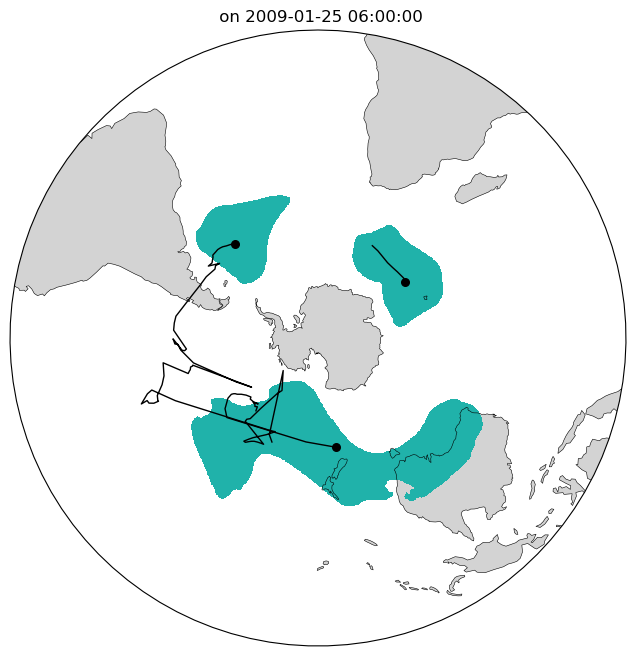

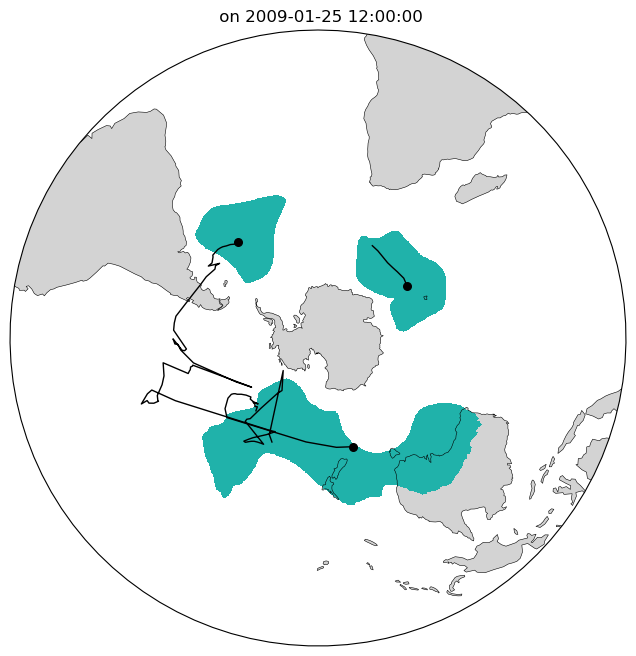

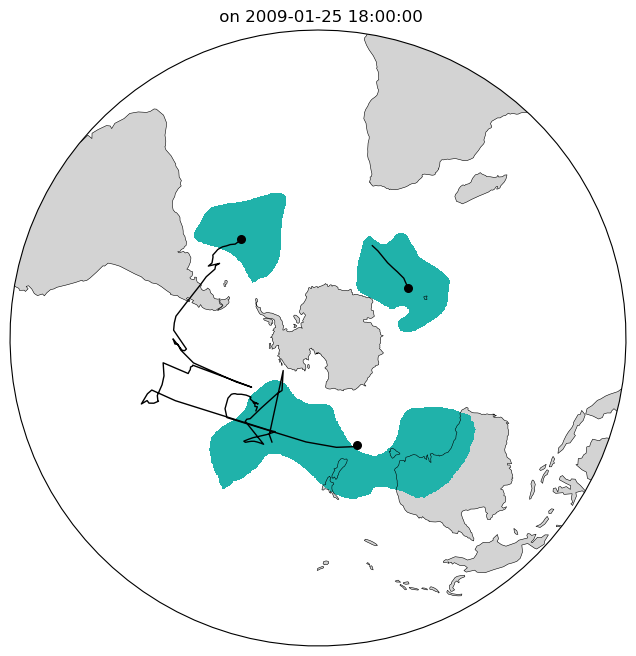

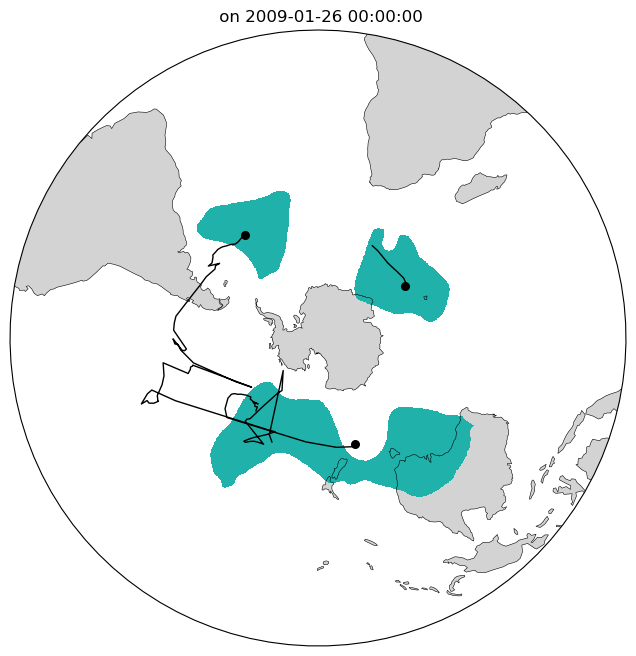

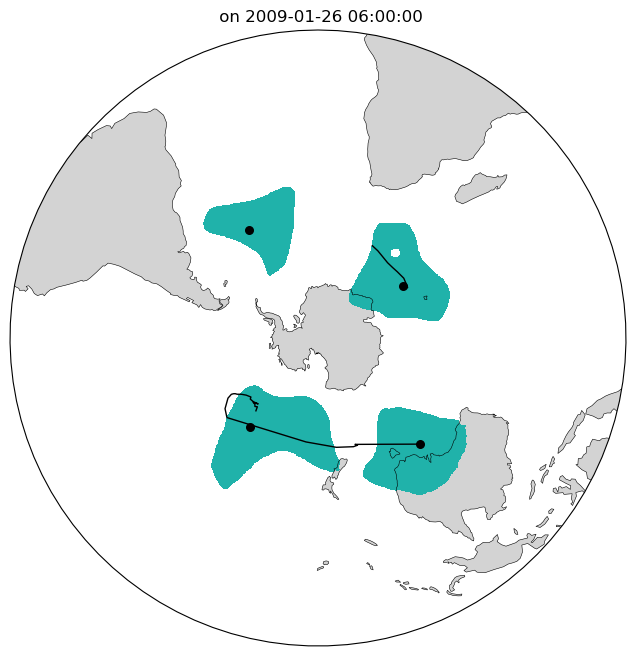

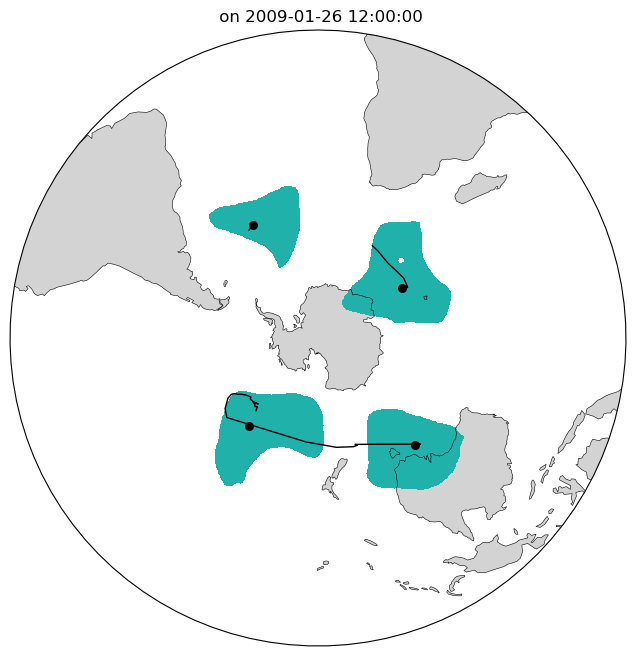

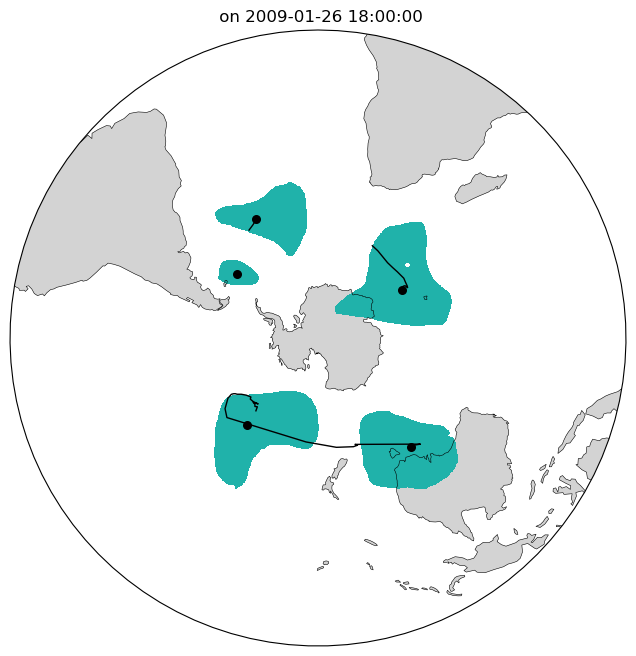

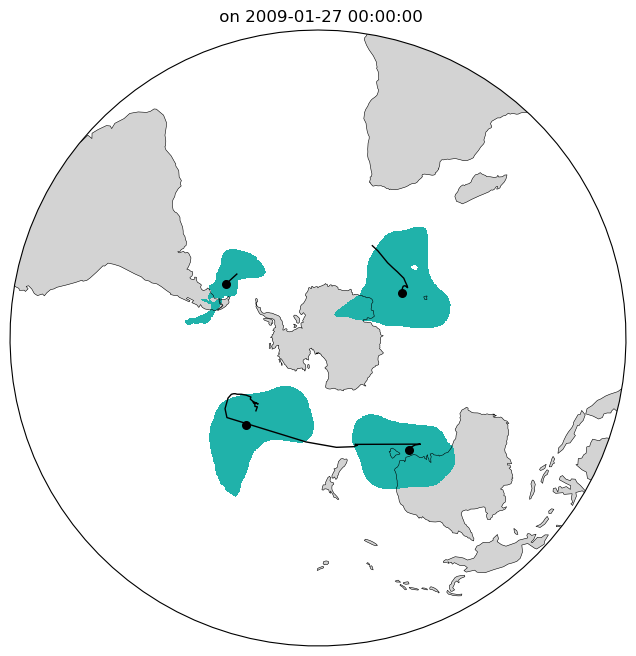

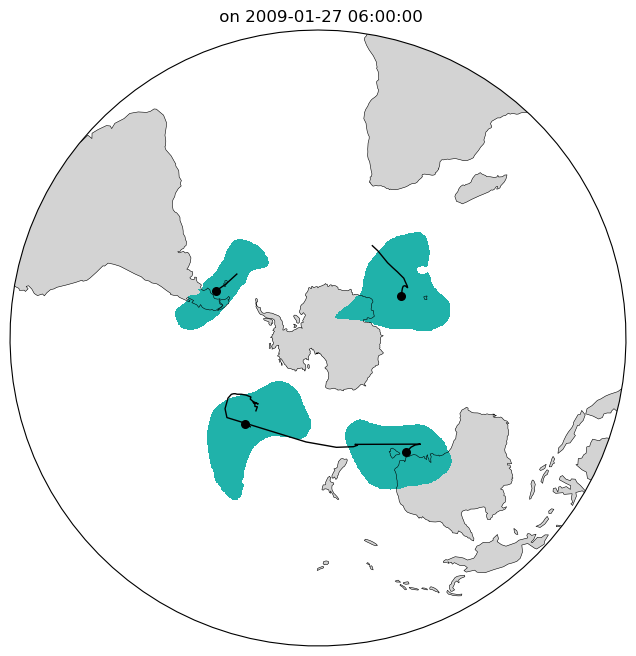

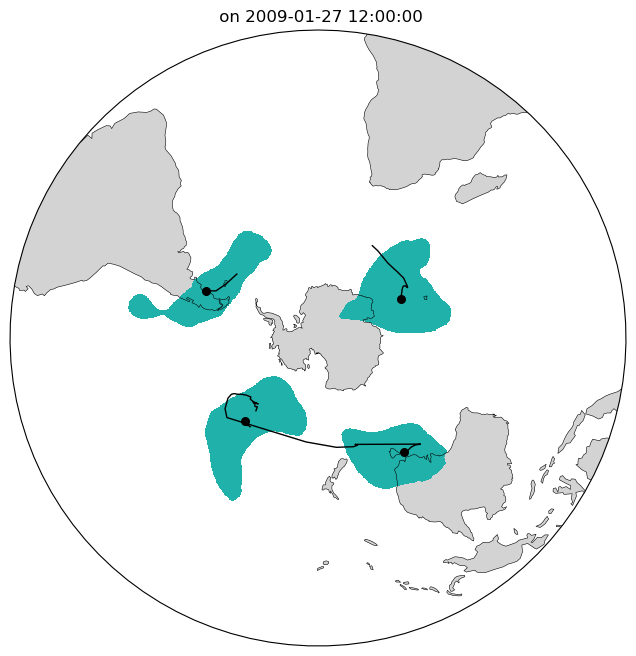

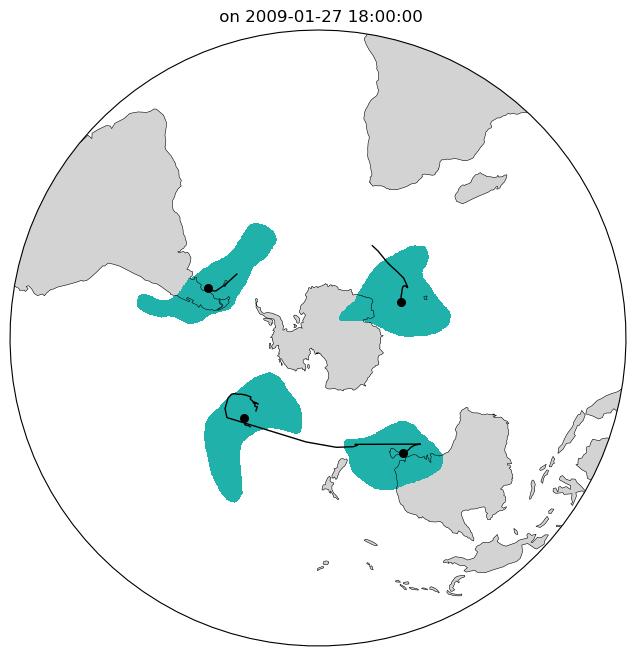

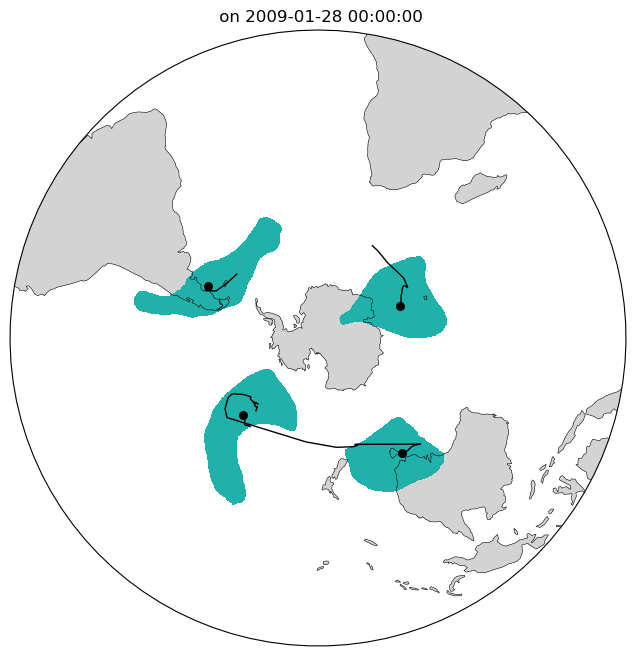

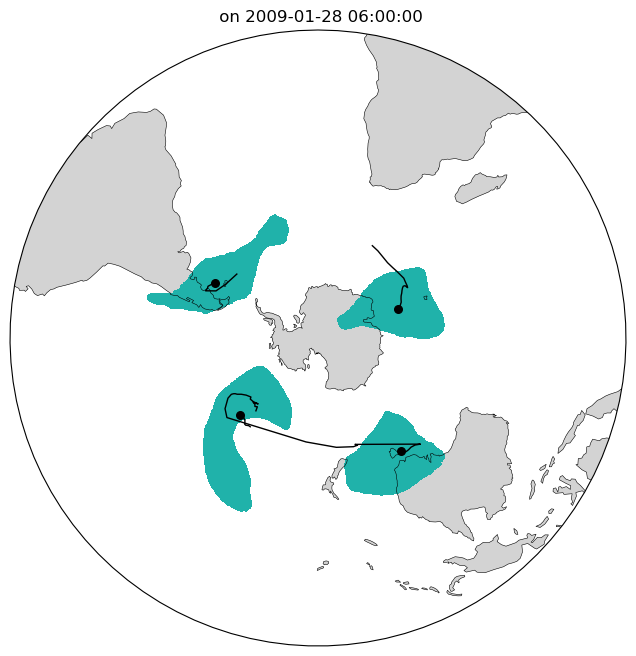

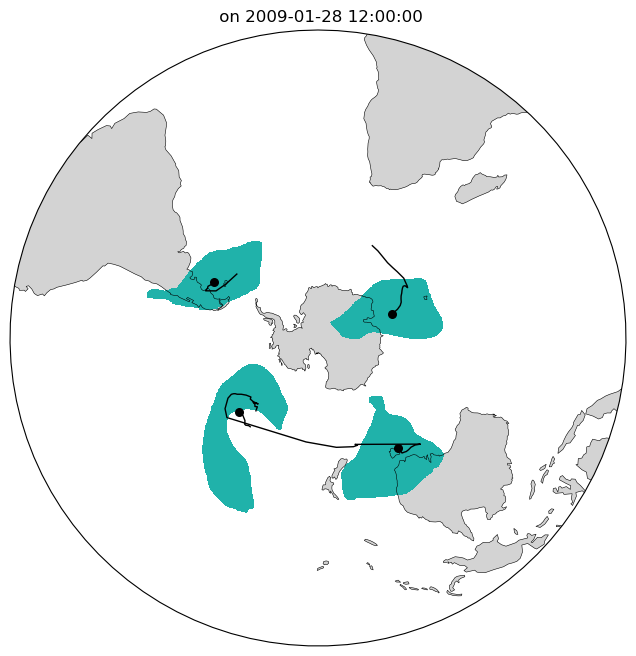

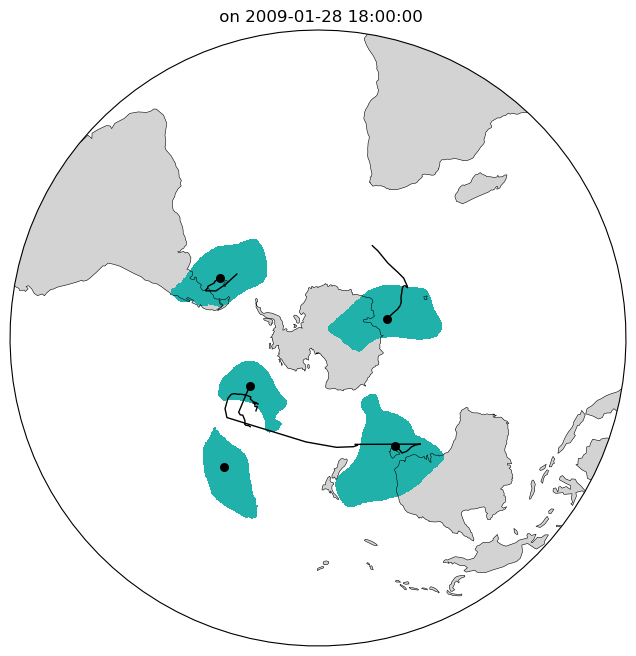

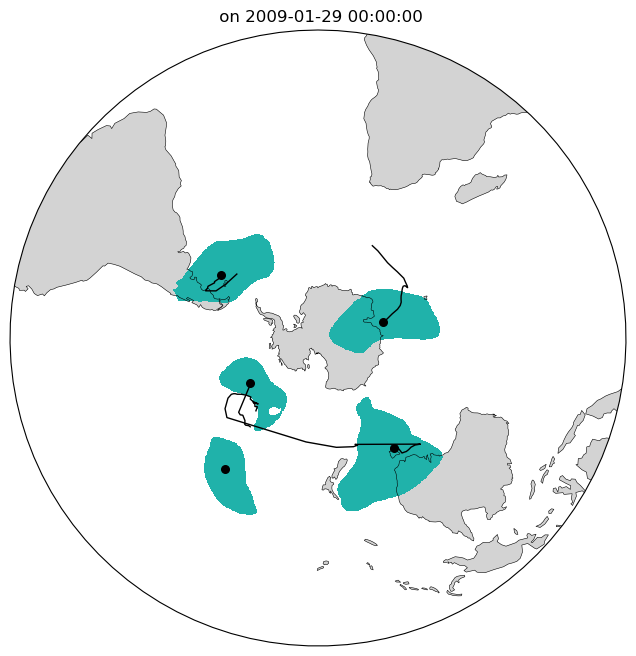

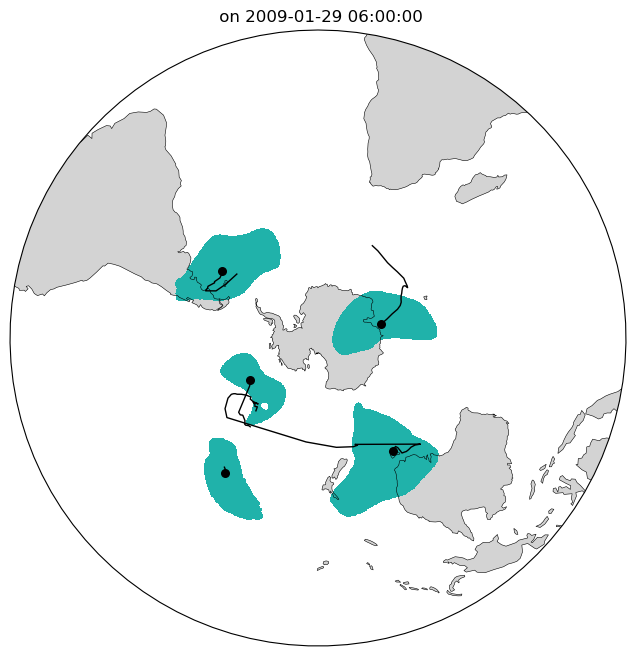

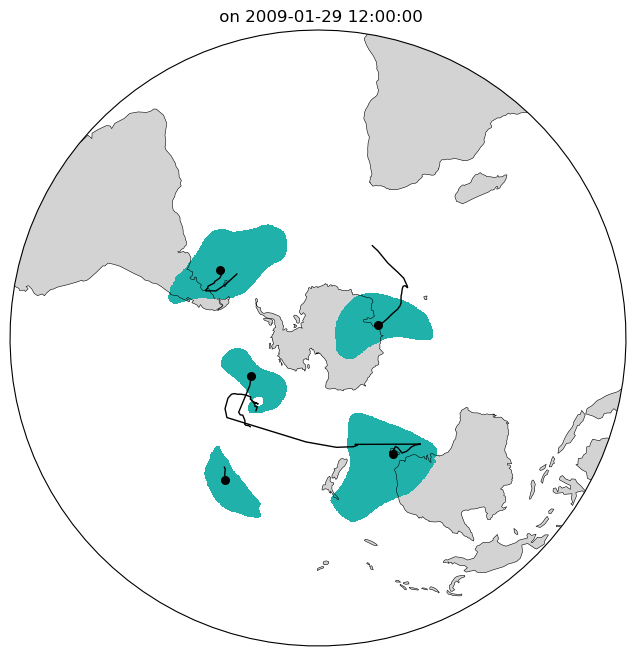

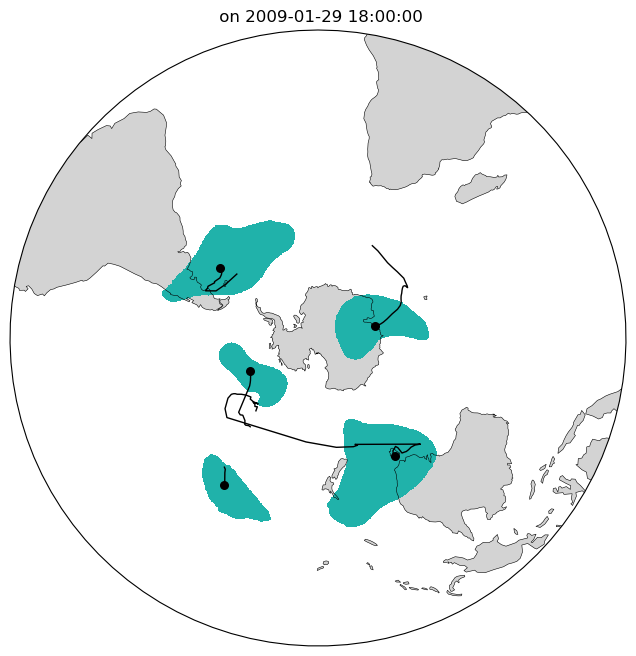

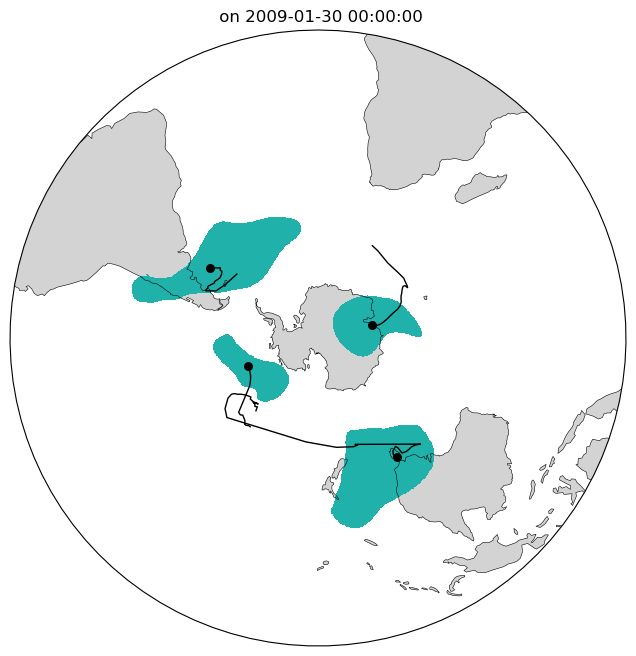

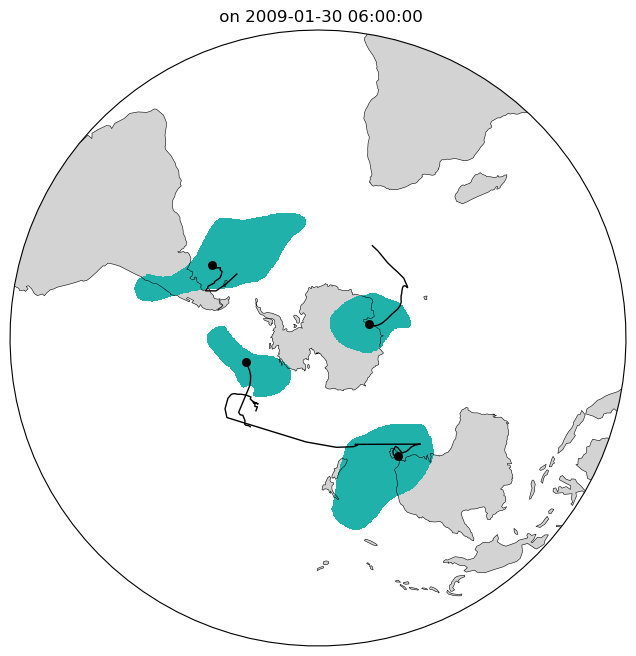

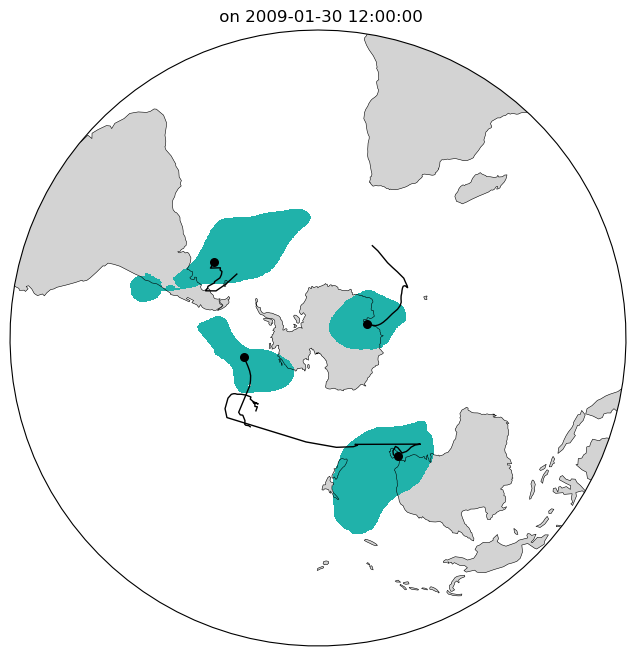

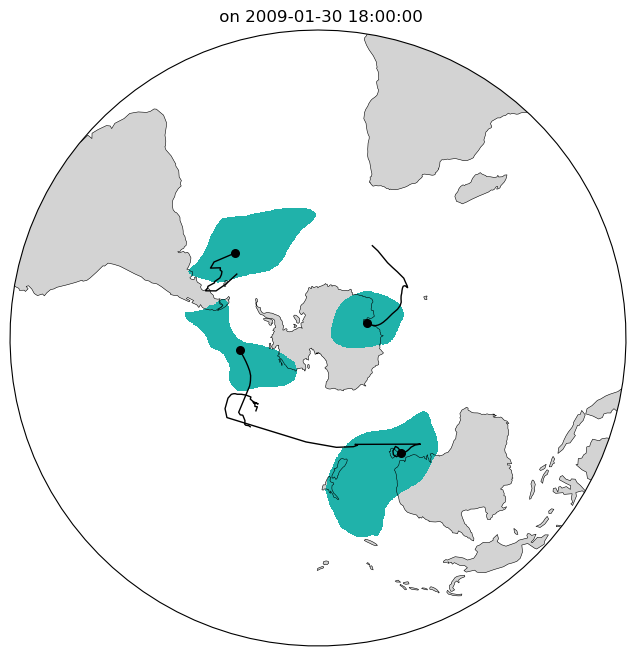

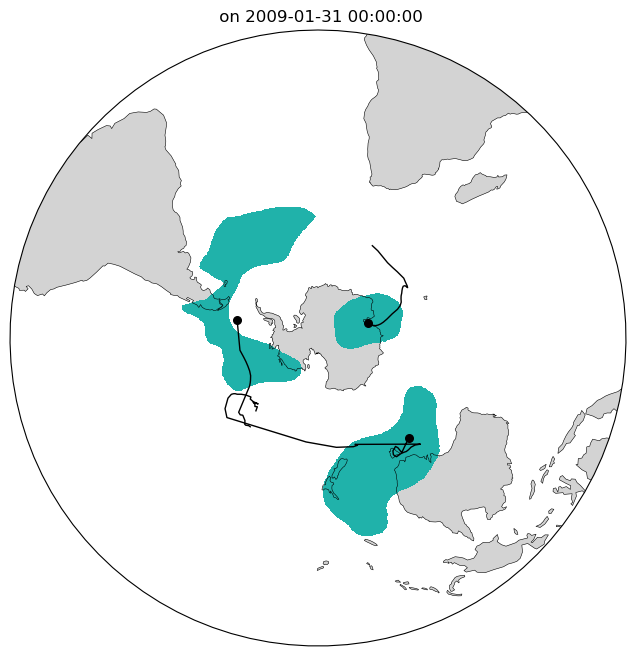

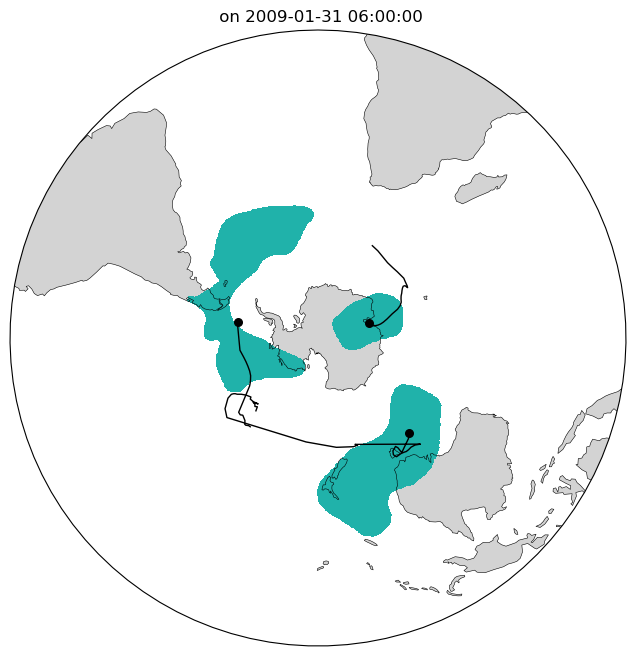

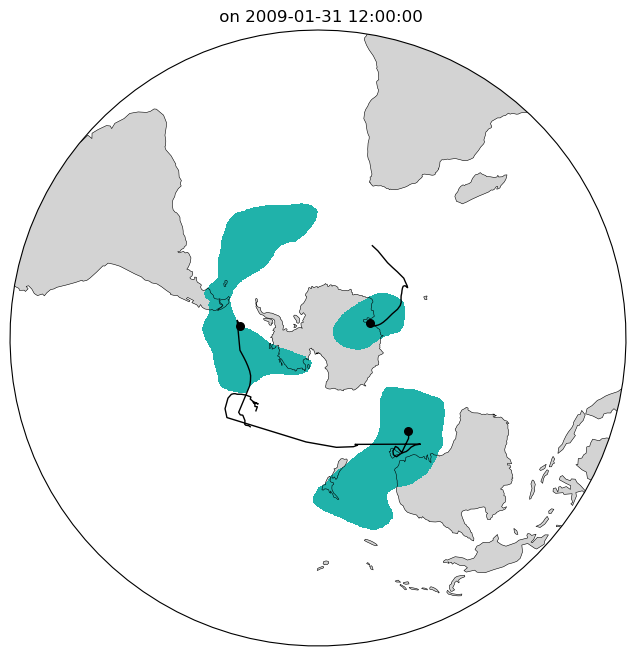

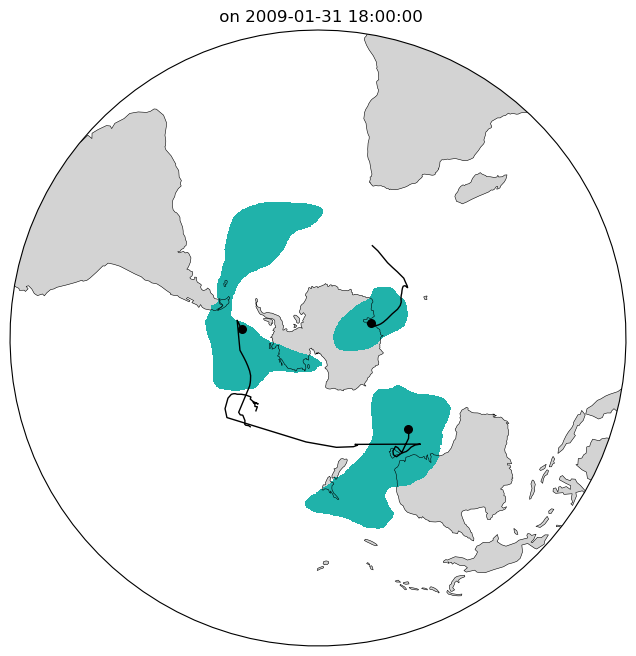

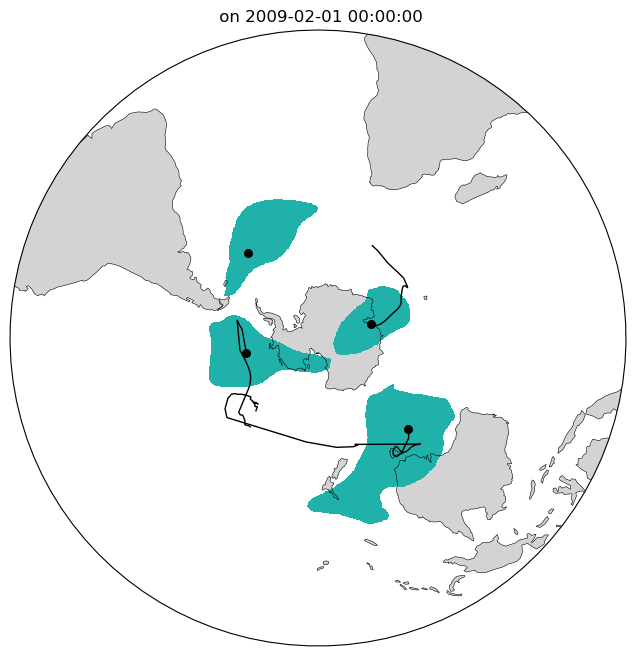


KeyboardInterrupt



In [13]:
import cartopy.crs as ccrs
for dt in generate_datetimes(datetime(2009,1,15),datetime(2009,2,10),interval=6):
    obj_xr_full=xr.open_dataset(casepath+'stitchBlobs/stitchBlobs_'+casename+'_'+dt.strftime('%Y%m')+'.nc')
    obj_xr=obj_xr_full.object_id
    obj_xr['longitude']=obj_xr_full.longitude
    obj_xr['latitude']=obj_xr_full.latitude
    
    plot_tracks_at_time(df_final2,obj_xr,dt,track_id_coord='bnum_merge',
                           projection=ccrs.SouthPolarStereo())

In [ ]:
#closest_points#[closest_points['prev_index']==pid]#.current_index.values[0]#.closest_track_id.values[0]

In [ ]:
#df_dt

In [ ]:
#df_final2[df_final2.bnum==15].iloc[10:40]

In [ ]:
#df_final2[df_final2.datetime==datetime(2009,2,10)]

In [ ]:
import cartopy.crs as ccrs
for dt in generate_datetimes(datetime(2009,2,1),datetime(2009,2,10),interval=6):
    obj_xr_full=xr.open_dataset(casepath+'stitchBlobs/stitchBlobs_'+casename+'_'+dt.strftime('%Y%m')+'.nc')
    obj_xr=obj_xr_full.object_id
    obj_xr['longitude']=obj_xr_full.longitude
    obj_xr['latitude']=obj_xr_full.latitude
    
    plot_tracks_at_time(df_final2,obj_xr,dt,
                           projection=ccrs.SouthPolarStereo())

In [ ]:
#df